In [1]:
!pip install huggingface_hub -q

In [2]:
!pip install wandb==0.16.0 -q

In [3]:
!pip install --upgrade datasets -q

In [4]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install git+https://github.com/surmenok/keras_lr_finder

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-gw4o91mw
  Running command git clone --filter=blob:none -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-gw4o91mw
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/surmenok/keras_lr_finder to /tmp/pip-req-build-5_cq73pk
  Running command git clone --filter=blob:none -q https://github.com/surmenok/keras_lr_finder /tmp/pip-req-build-5_cq73pk
  Resolved https://github.com/surmenok/keras_lr_finder to commit 3c8fe719d7e3291a1f72ff8a9a1c51e9fc5d520b
  Preparing metadata (setup.py) ... done


In [5]:
import os
import io
import glob
import math
import wandb
import random
import numpy as np
import pandas as pd
from PIL import Image 
from PIL import ImageOps
import huggingface_hub
from tensorflow_examples.models.pix2pix import pix2pix


from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import utils
from tensorflow.keras import layers, models
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import ResNet50


import matplotlib.pyplot as plt
from datasets import load_dataset
from wandb.keras import WandbCallback
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import albumentations as A
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize, Rotate, GaussNoise, RandomScale

In [6]:
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 1464
    })
    val: Dataset({
        features: ['image', 'mask'],
        num_rows: 1449
    })
})

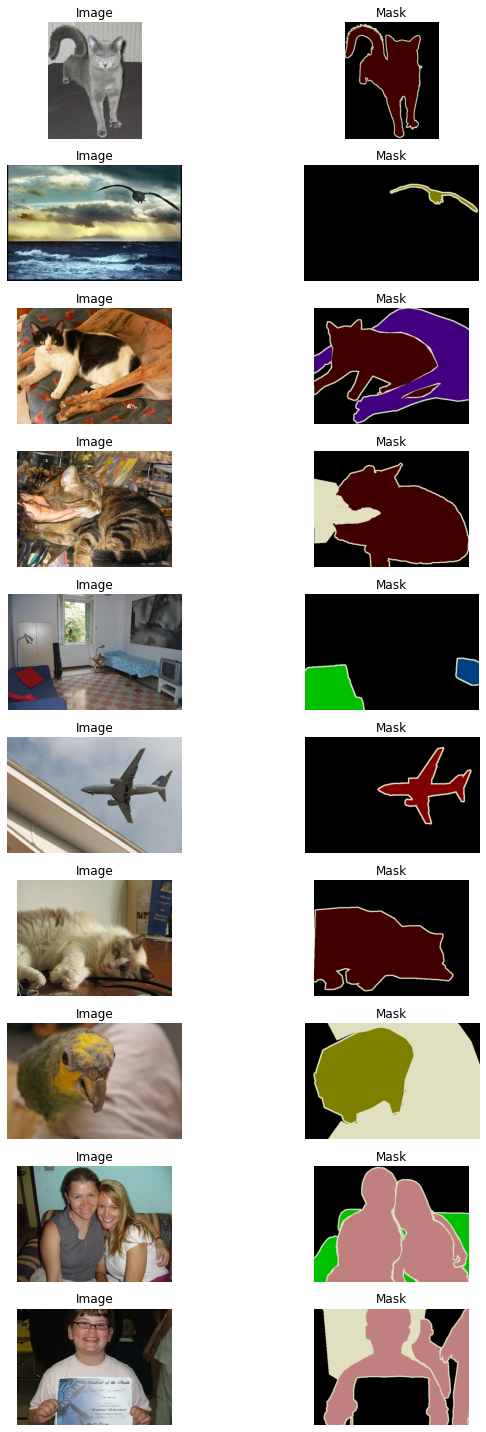

In [8]:
# 이미지와 마스크 데이터셋에서 10개의 샘플을 무작위로 선택
random.seed(42)  # 무작위 결과 재현을 위해 시드 설정
selected_samples = random.sample(range(len(dataset['train'])), 10)

# 선택된 샘플의 이미지와 마스크 시각화
fig, axes = plt.subplots(10, 2, figsize=(10, 20))

for i, sample_idx in enumerate(selected_samples):
    image = dataset['train'][sample_idx]['image']
    mask = dataset['train'][sample_idx]['mask']

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask)
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

In [10]:
from PIL import ImageOps

def data_concat(dataset):
    
    img_arr = []
    seg_arr = []

    img_arr_temp = dataset['train']['image'] + dataset['val']['image']

    seg_arr_temp = dataset['train']['mask'] + dataset['val']['mask']
    
    for img, seg in zip(img_arr_temp, seg_arr_temp):
        img = np.array(img.resize((IMG_WIDTH, IMG_HEIGHT)))
        seg = np.argmax(np.array(seg.resize((IMG_WIDTH, IMG_HEIGHT))), axis=-1)
        seg[seg == 255] = 21
        img_arr.append(img)
        seg_arr.append(seg)
    
    return np.array(img_arr), np.array(seg_arr)

In [11]:
full_dataset = tf.data.Dataset.from_tensor_slices(data_concat(dataset))

In [12]:
print(full_dataset)

<TensorSliceDataset shapes: ((256, 256, 3), (256, 256)), types: (tf.uint8, tf.int64)>


In [13]:
DATASET_SIZE = 2913

In [14]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size = DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [15]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

### We need some agumentation while loading the training set in order to prevent overfitting 

In [16]:
def load_image_train(input_image, input_mask):
    input_mask = input_mask[..., np.newaxis]

    # 데이터 증강
    # 랜덤 좌우 반전
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # 랜덤 밝기 조정
    input_image = tf.image.random_brightness(input_image, max_delta=0.1)

    # 랜덤 대비 조정
    input_image = tf.image.random_contrast(input_image, lower=0.8, upper=1.2)

    # 랜덤 색상 조정
    input_image = tf.image.random_hue(input_image, max_delta=0.08)
    input_image = tf.image.random_saturation(input_image, lower=0.7, upper=1.3)

    # 랜덤 회전
    input_image = tf.image.rot90(input_image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    input_mask = tf.image.rot90(input_mask, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # 정규화
    input_image, input_mask = normalize(input_image, input_mask)

    input_mask = input_mask[:, :, 0]

    return input_image, input_mask


In [17]:
def load_image_test(input_image, input_mask):
    input_mask = input_mask[np.newaxis, ...]
    
    
    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [18]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE

In [19]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val   = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [20]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

### show an example of image and mask

(256, 256, 3)


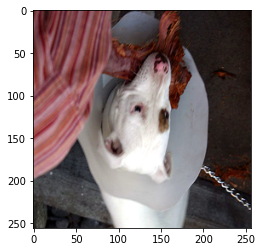

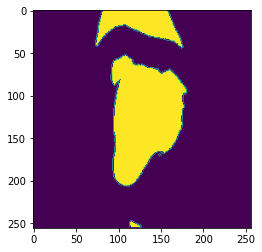

(256, 256, 3)


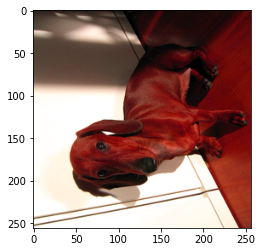

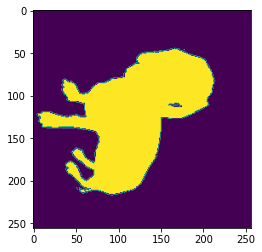

(256, 256, 3)


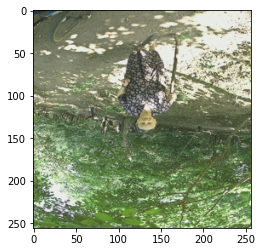

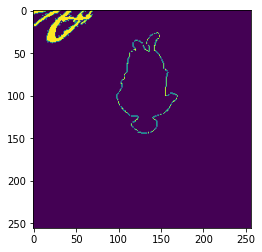

(256, 256, 3)


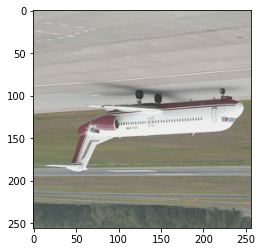

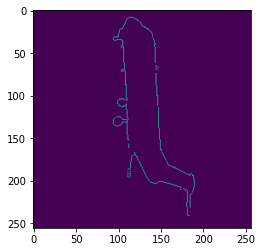

(256, 256, 3)


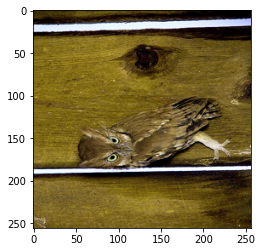

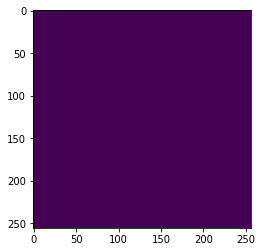

In [21]:
for image, mask in train.take(5):
    sample_image, sample_mask = image, mask
    plt.imshow(sample_image)
    print(sample_image.shape)
    plt.show()
    plt.imshow(sample_mask)
    plt.show()

In [22]:
# Define the convolutional block
def conv_block(input_tensor, num_filters, dropout_rate=0.0):
    x = layers.Conv2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

# Define the encoder block
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)  # 컨볼루션 블록을 적용합니다.
    p = layers.MaxPooling2D((2, 2))(x)  # 2x2 맥스 풀링을 적용하여 특징 맵의 크기를 줄입니다.
    return x, p  # 컨볼루션 블록의 출력과 풀링 레이어의 출력을 반환합니다.

# Define the decoder block
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)  # 업샘플링을 위해 전치 컨볼루션을 적용합니다.
    x = layers.concatenate([x, concat_tensor], axis=-1)  # 업샘플링된 특징 맵과 인코더의 해당 특징 맵을 연결합니다.
    x = conv_block(x, num_filters)  # 연결된 특징 맵에 컨볼루션 블록을 적용합니다.
    return x  # 결과 텐서를 반환합니다.

# Define the U-Net model
def build_model(input_shape, num_classes):
    # ResNet50 백본 모델 불러오기
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # 백본 모델의 출력을 U-Net의 인코더 부분으로 사용
    x1 = backbone.get_layer('conv2_block3_out').output
    x2 = backbone.get_layer('conv3_block4_out').output
    x3 = backbone.get_layer('conv4_block6_out').output
    x4 = backbone.get_layer('conv5_block3_out').output

    # Bridge
    b = conv_block(x4, 1024, dropout_rate=0.5)

    # Decoder
    d1 = decoder_block(b, x3, 512)
    d2 = decoder_block(d1, x2, 256)
    d3 = decoder_block(d2, x1, 128)

    # 추가적인 디코더 블록
    x0 = backbone.get_layer('conv1_relu').output
    d4 = decoder_block(d3, x0, 64)
    d4_up = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(d4)
    d4_up = layers.Activation("relu")(d4_up)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1))(d4_up)

    model = models.Model(inputs=backbone.input, outputs=outputs, name="U-Net-with-ResNet50-Backbone")

    return model

### find the optimal learning rate

In [23]:
# 모델 생성 예시
model = build_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes=21)

In [24]:
# OUTPUT_CHANNELS = 22
# model = unet_model(OUTPUT_CHANNELS)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### From the above figure, 1e-4 is the optimal learning rate

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [26]:
# OUTPUT_CHANNELS = 22
# model = unet_model(OUTPUT_CHANNELS)
# model.compile(optimizer=optimizer,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [27]:
OUTPUT_CHANNELS = 22
model = build_model((IMG_HEIGHT, IMG_WIDTH, 3), num_classes=21)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

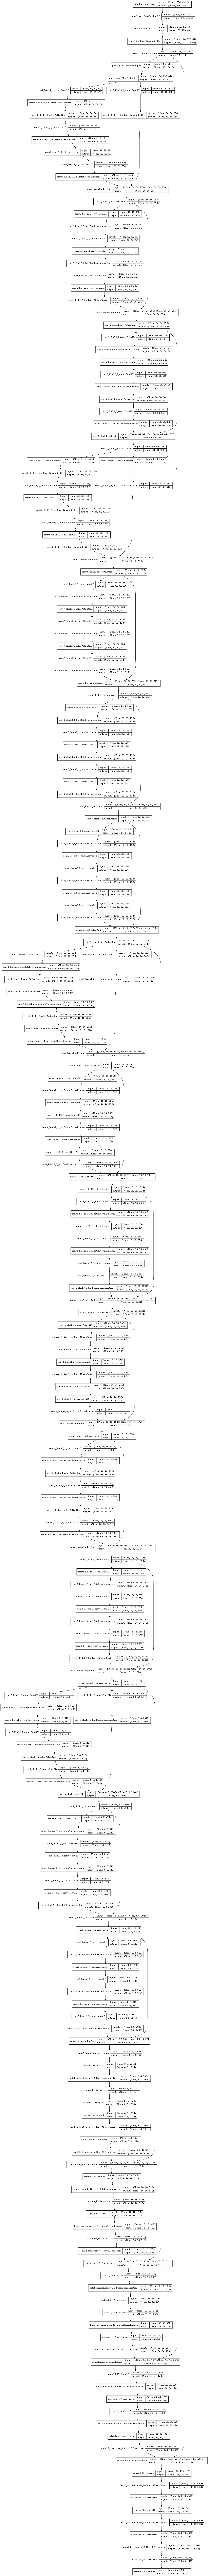

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [31]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)

Epoch 1/5
127/127 [==============================] - 137s 565ms/step - loss: 1.8874 - accuracy: 0.7104 - val_loss: 0.9227 - val_accuracy: 0.8908
Epoch 2/5
127/127 [==============================] - 68s 492ms/step - loss: 0.6406 - accuracy: 0.8823 - val_loss: 0.6375 - val_accuracy: 0.8648
Epoch 3/5
127/127 [==============================] - 62s 489ms/step - loss: 0.4310 - accuracy: 0.8843 - val_loss: 0.4512 - val_accuracy: 0.9024
Epoch 4/5
127/127 [==============================] - 62s 489ms/step - loss: 0.3624 - accuracy: 0.8929 - val_loss: 0.6108 - val_accuracy: 0.8711
Epoch 5/5
127/127 [==============================] - 62s 489ms/step - loss: 0.3188 - accuracy: 0.8985 - val_loss: 0.5406 - val_accuracy: 0.8877


In [32]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [33]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()

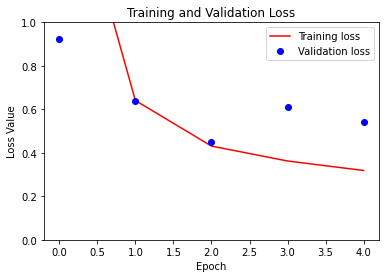

In [34]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

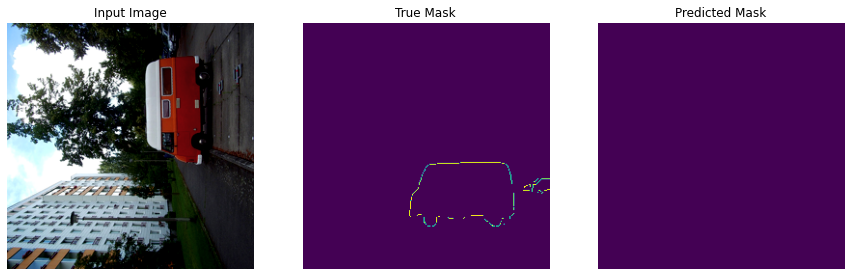

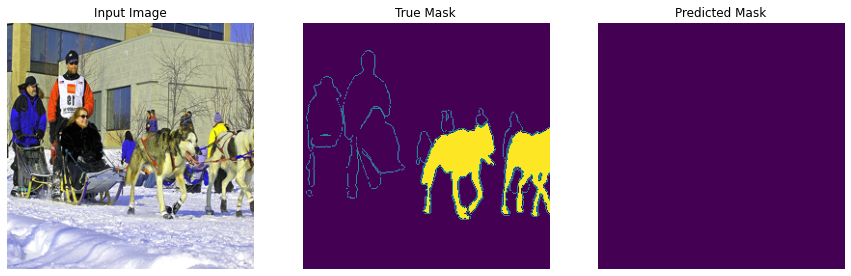

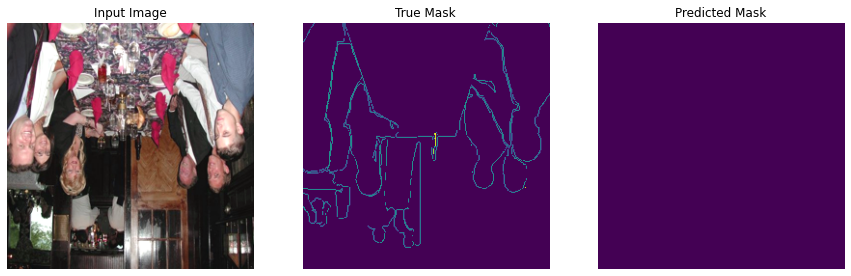

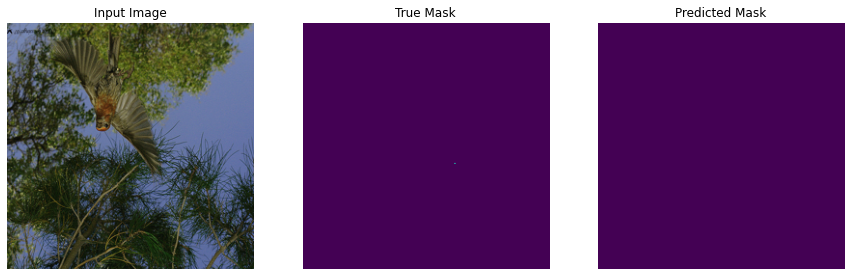

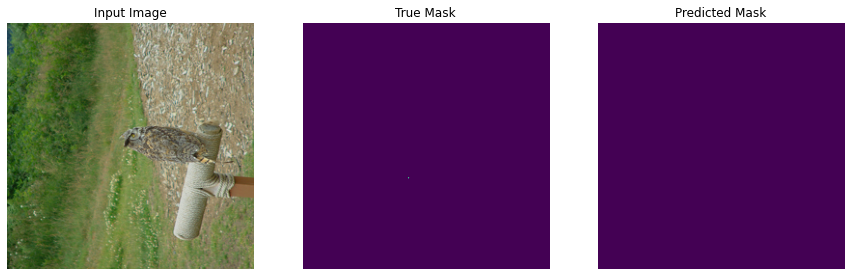

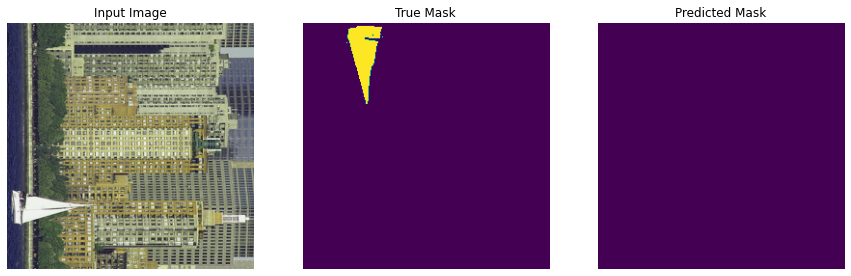

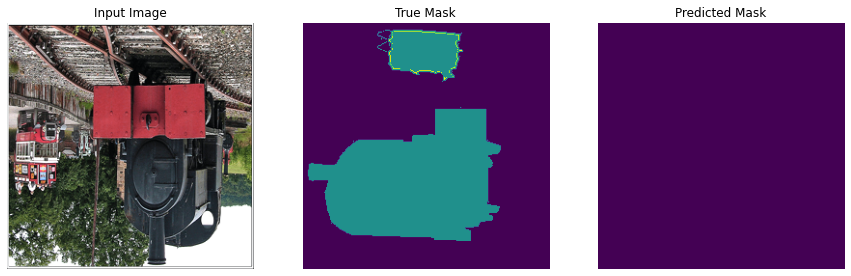

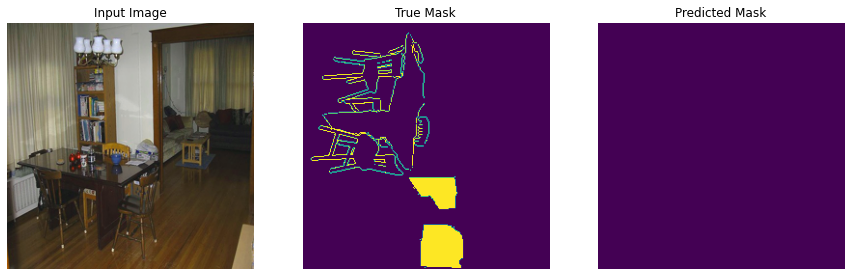

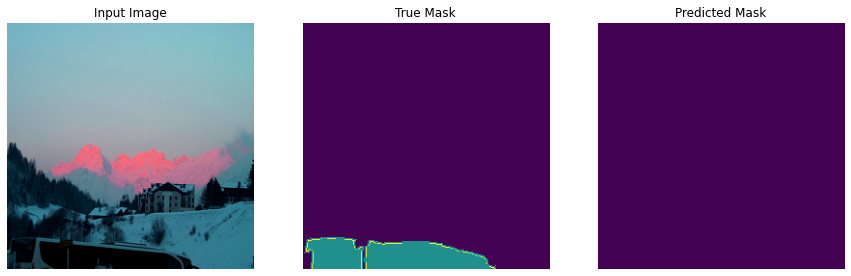

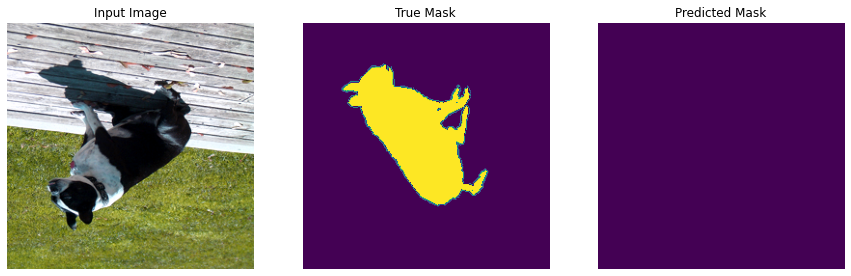

In [35]:
show_predictions(train_dataset, num =10)

In [ ]:
show_predictions(test_dataset.shuffle(buffer_size=64), num =10)

In [ ]:
show_predictions(val_dataset.shuffle(buffer_size=64), num =10)

In [ ]:
model.evaluate(test_dataset)

### Model inference and extract mask

In [ ]:
!mkdir source
!mkdir mask

In [ ]:
cnt = 0
for image, mask in train_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    pred_mask = (np.array(pred_mask) !=0).astype(int)
#     print(image[0].shape)
#     print(pred_mask.shape)
    Image.fromarray((np.array(image[0]*255).astype(np.uint8))).save(f"source/source_{cnt}.jpg")
    Image.fromarray((pred_mask[:,:,0]*255).astype(np.uint8)).save(f"mask/mask_{cnt}.jpg")
    display([image[0], pred_mask[:, :, 0], image[0] * pred_mask])
    cnt += 1

In [ ]:
# cat_img = np.array(Image.open("../input/pascal-voc-2012/VOC2012/JPEGImages/2007_000241.jpg").resize((256, 256)))
# pred_mask = model.predict(cat_img[np.newaxis,...])
# mask = create_mask(pred_mask)
# mask = np.array(mask!=0, dtype=int)

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.login(key = '2f9ea9f46398a3991e48c7ad0e211dd29acd44b5')

In [ ]:
sweep_config = {
    "name": "sweep_test_cv",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [ ]:
def train():
    default_config = {
        "input" : (256,256,3),
        "filter" : 8,
        "kernel" : (3,3),
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config


    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=config.metrics)

    # WandbCallback 함수는 후술합니다.
    model.fit(train_dataset,
              epochs=config.epoch,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_steps=VALIDATION_STEPS,
              validation_data=val_dataset,
              callbacks = [WandbCallback(validation_data = val_dataset,
                                         predictions = 10,
                                         input_type = "auto",
                                         output_type = "segmentation_mask")])
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [ ]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = None,
                       project = 'test_project')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)